In [1]:
import pandas as pd
import numpy as np
import os
from common.custom_colors import mycolor
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

def get_cdf(x, bins=None):
    if bins is None:
        bins = np.linspace(np.min(x), np.max(x), 100)
    hist, _ = np.histogram(x, bins, density=False)
    hist = hist / x.size
    cdf = np.cumsum(hist)
    return cdf, bins

# Plot CDF of errors before correction and after correction with models trained on different devices

We recorded the test results in files from the root directory `root_dir`, which contain the true errors and the predicted errors with models trained on different devices. We recreate Fig. 5 from the paper, which shows the CDF of the original distance errors vs. the corrected errors using models trained on the same or on different devices.

In [3]:
root_dir = "../data/trained_models_error_prediction/models_paper/"
all_devices = ["3db_midas3", "dw3000", "tdsr"]
root_run = "1655136635"

# Initialize the dict
dict_results = {}
for train_dev in all_devices:
    dict_results[train_dev] = {}
    for test_dev in all_devices:
        dict_results[train_dev][test_dev] = {}
        dict_results[train_dev][test_dev]["y_true"] = []
        dict_results[train_dev][test_dev]["y_pred"] = []

# Add data to the dict
for train_dev in all_devices:
    for i_set in range(10):
        model_dir = "train_{}_test_{:.0f}".format(train_dev, i_set)
        for test_dev in all_devices:
            test_file = "test_{}_predicted_true_{}.csv".format(test_dev, root_run)
            test_path = os.path.join(root_dir, model_dir, test_file)
            df = pd.read_csv(test_path)
            
            for field in df.columns:
                dict_results[train_dev][test_dev][field].extend(list(df[field]))

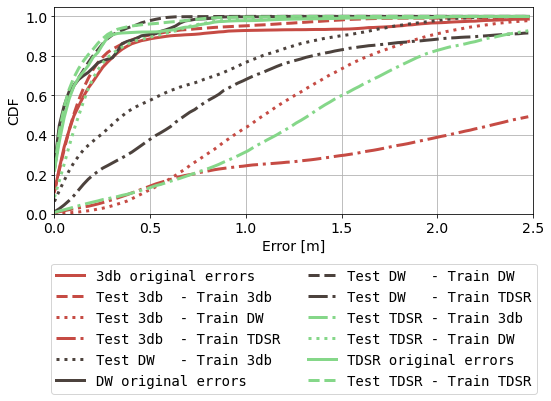

In [6]:
# Process and plot data
plot_dict = {
    "3db_midas3": {
        "color": mycolor["color1"],
        "pretty_name": "3db",
        "test_linestyle": {
            "3db_midas3": "--",
            "tdsr": "-.",
            "dw3000": ":",
        }
    },
    "tdsr": {
        "color": mycolor["color3"],
        "pretty_name": "TDSR",
        "test_linestyle": {
            "3db_midas3": "-.",
            "tdsr": "--",
            "dw3000": ":",
        }
    },
    "dw3000": {
        "color": mycolor["neutral1"],
        "pretty_name": "DW",
        "test_linestyle": {
            "3db_midas3": ":",
            "tdsr": "-.",
            "dw3000": "--",
        }
    }
}

fig, ax = plt.subplots(figsize=(8, 10))
bins = np.linspace(0, 2.5, 100)

for test_dev in all_devices:
    for train_dev in all_devices:
        y_true = np.array(dict_results[train_dev][test_dev]["y_true"])
        y_pred = np.array(dict_results[train_dev][test_dev]["y_pred"])
        
        err_orig = np.abs(y_true)
        err_corr = np.abs(y_pred - y_true)
        
        m_err_orig = np.mean(err_orig)
        m_err_corr = np.mean(err_corr)
        std_err_orig = np.std(err_orig)
        std_err_corr = np.std(err_corr)
        
        # Compute the % of decrease in the error after the correction
        p_m_err = 100 * (m_err_orig - m_err_corr) / m_err_orig
        p_std_err = 100 * (std_err_orig - std_err_corr) / std_err_orig
        
        cdf_orig, _ = get_cdf(err_orig, bins)
        cdf_corr, _ = get_cdf(err_corr, bins)
        
        # Compare original errors with corrected errors
        label1 = "Test {:<4s} - Train {:<4s}".format(
            plot_dict[test_dev]["pretty_name"], plot_dict[train_dev]["pretty_name"])
        if train_dev == test_dev:
            label2 = "{} original errors".format(
                plot_dict[test_dev]["pretty_name"])
            ax.plot(bins[:-1], cdf_orig, label=label2, 
                 color=plot_dict[test_dev]["color"], linestyle="-", linewidth=3)
        ax.plot(bins[:-1], cdf_corr, label=label1, 
                color=plot_dict[test_dev]["color"], 
                linestyle=plot_dict[test_dev]["test_linestyle"][train_dev], linewidth=3)
            

ax.legend(prop={"family":"monospace"}, loc="lower center", bbox_to_anchor=(0.5, -0.9), ncol=2)
ax.grid("--")
ax.set_xlabel("Error [m]")
ax.set_ylabel("CDF")
ax.set_xlim((0, 2.5))
ax.set_ylim((0, 1.05))
fig.tight_layout()
plt.show()